# VAR GLLVM

 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable acpoisson for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a stationary vector-autoregressive model of first order with trend


$$
z_{i,t} = \beta_0 + \beta_1 t + Az_{i,t-1} +  \epsilon_{i,t}\\
||A||_2 < 1\\
\epsilon_{i,t} \sim N(0, I)\\
$$

initialization for $t=0$:

$$
z_{i, 1} \sim N(0, \Sigma_{z1})\\
\Sigma_{z1} = 
\begin{pmatrix}
    \sigma_{z1,1}^2&\\
    &\sigma_{z1,2}^2
\end{pmatrix}\\
\sigma_{z1,i}>0 \forall i
$$

Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Estimating $\epsilon, u$
To estimate $z, u$, we use a neural network. The neural network learns to estimate linpar from condmu. Once linpar is estimated, using the parameters of the model we can get back to the shocks (of known distributions). The training of the neural network is guided by the knowledge of the parameters. In essence, the neural network learns to  estimate the linear parameter from the responses (or transformation thereof), which is an easy task. Once the linear parameter is known, we obtain the Z as coefficients for lambda and u_scaled as reminders. (since the goal is to estimate z and u given the parameter values, we can use them). Once we have z, we can get epsilon. We then rescale all variables using the known parameters so all epsilon and u are N(0,I), and thus directly comparable on precisely the same scale. We then use MSE on all these together to train the neural network. Even though it is a multi-objective, we know their weights. This provides speedups of several orders of magnitudes, compared to computing the solution directly.

### Imputatin of Missig Completely at Random data:
To estimate the model with missing completely at random data (MCAR), we iteratively impute the observed and simulated samples with the conditional mean of the data.



# TODO:
* Improve the training loop
* test that the operations in forward are correct
* in the forward fct of the encoder, test that the gradients of the model used as argument are NOT CHANGED
* Implement conditional Imputation

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_value_
import numpy as np
from VAR1 import VAR1
from typing import Type, Optional, Tuple
import matplotlib.pyplot as plt
import VARGLLVM
import copy


## Training Loops

In [2]:
batch_size = 250
num_var = 10
num_latent = 1
num_covar = 2
seq_length = 10
prob_mis = 0
x = torch.randn((batch_size, seq_length, num_covar))

response_types = {
    'bernoulli': np.arange(5),
    'poisson': np.arange(5, num_var)
}

model_true = VARGLLVM.VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=True,
                 VAR1_intercept = True,
                 VAR1_slope =True,
                 fixed_first_loading=False) # set to true to fix the first loadings to 1. but we shouldn't do this imho right?

model = VARGLLVM.VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=True,
                 VAR1_intercept = True,
                 VAR1_slope =True,
                 fixed_first_loading=False)

encoder = VARGLLVM.Encoder(num_var, num_covar, num_latent, num_hidden=10)

# Some data modification to check if we actually learn anything hehe
with torch.no_grad():
    if num_latent == 2:
        model_true.A[:] = torch.Tensor([[0.8, 0.2], [0.1, 0.6]]) # include some amount of auto-correlation
        model_true.VAR1_slope[:] = torch.Tensor([0.1, -0.1])
    else:
        model_true.A[:] = torch.Tensor([[0.6]])
        model_true.VAR1_slope[:] = torch.Tensor([0.1])
    model_true.logvar_u[:] = torch.ones_like(model_true.logvar_u)*0.5

    data_true = model_true.sample(batch_size, seq_length=seq_length, x=x)
    data_true['mask'] = torch.rand_like(data_true['y']) < 0.2
    y_nomis = data_true['y'].clone()

In [3]:
model_true.wz

Parameter containing:
tensor([[-0.5367, -1.0554, -0.8103, -0.9890,  0.1511,  0.0470,  0.2570, -1.0117,
         -0.2736,  0.6700]], requires_grad=True)

In [4]:
model.wz

Parameter containing:
tensor([[-0.0652,  0.7034, -0.4486, -1.9177, -1.3658, -0.5753,  0.1513,  1.5021,
          0.4991, -1.7229]], requires_grad=True)

In [5]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to device
# Move the models and data to device
encoder = encoder.to(device)
model = model.to(device)
data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device



In [6]:

# Define optimizer and criterion as before
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
encoder_criterion = nn.MSELoss()

model_optimizer = torch.optim.SGD(model.parameters(), lr=1)
model_criterion = VARGLLVM.MELoss()

# Define schedulers
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=50, gamma=0.8)
model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=50, gamma=0.8)

impute_with = 0.5


In [7]:
all_params = []

for i in range(500):
    with torch.no_grad():
        data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], data_true['mask'], data_true['x'], impute_with = impute_with)
        
    encoder_loss = VARGLLVM.train_encoder(
        encoder, 
        model, 
        encoder_criterion, 
        encoder_optimizer, 
        num_epochs=5, 
        sample=True,
        batch_size=data_true['x'].shape[0],
        seq_length=data_true['x'].shape[1],
        x=data_true['x'],
        data=None,
        verbose=False,
        mask=data_true['mask'], 
        impute_with=impute_with)
    encoder_scheduler.step()  # Step the encoder scheduler
    
    decoder_loss = VARGLLVM.train_decoder(
        model, 
        encoder, 
        model_criterion, 
        model_optimizer, 
        data_true,
        num_epochs=1, 
        transform=True,
        verbose=False,
        mask = data_true['mask'],
        impute_with=impute_with)
    
    model_scheduler.step()  # Step the model scheduler

    with torch.no_grad():
        encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
        _, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])
        loss = torch.mean(torch.pow(decoded_mean - data_true['y'],2))
    
    print(f'var_u: {torch.exp(model.logvar_u)}')
    print(f'Iteration {i}: encoder loss {encoder_loss}, decodeur: {decoder_loss}, overall: {loss.detach().numpy()}')
    all_params.append(copy.deepcopy(model.state_dict()))



    


var_u: tensor([0.9622, 0.9868, 0.9512, 1.0513, 0.9512, 1.0346, 1.0182, 1.0513, 0.9964,
        1.0513], grad_fn=<ExpBackward0>)
Iteration 0: encoder loss 1.0641334056854248, decodeur: 49.977256774902344, overall: 23677.220703125
var_u: tensor([0.9295, 1.0312, 0.9048, 1.0000, 0.9161, 0.9841, 1.0704, 1.0370, 1.0475,
        1.1052], grad_fn=<ExpBackward0>)
Iteration 1: encoder loss 1.0004346370697021, decodeur: 51.449913024902344, overall: 23405.357421875


var_u: tensor([0.9224, 1.0841, 0.9512, 1.0414, 0.9126, 0.9960, 1.1253, 0.9864, 0.9964,
        1.1618], grad_fn=<ExpBackward0>)
Iteration 2: encoder loss 1.006285548210144, decodeur: 41.815059661865234, overall: 22597.51953125
var_u: tensor([0.9120, 1.0942, 0.9779, 1.0935, 0.8966, 0.9890, 1.1830, 1.0175, 1.0475,
        1.2214], grad_fn=<ExpBackward0>)
Iteration 3: encoder loss 1.0082250833511353, decodeur: 44.07830810546875, overall: 20695.521484375
var_u: tensor([0.8675, 1.0803, 0.9302, 1.0966, 0.8590, 1.0397, 1.2436, 0.9679, 0.9964,
        1.2840], grad_fn=<ExpBackward0>)
Iteration 4: encoder loss 0.9367721080780029, decodeur: 34.863677978515625, overall: 18048.1484375
var_u: tensor([0.8252, 1.0799, 0.9596, 1.0809, 0.8171, 1.0639, 1.3074, 1.0175, 1.0475,
        1.3499], grad_fn=<ExpBackward0>)
Iteration 5: encoder loss 0.940351128578186, decodeur: 38.56787872314453, overall: 18307.21875
var_u: tensor([0.7850, 1.1352, 0.9731, 1.1363, 0.8181, 1.1185, 1.3744, 0.9679, 0.9964,
        

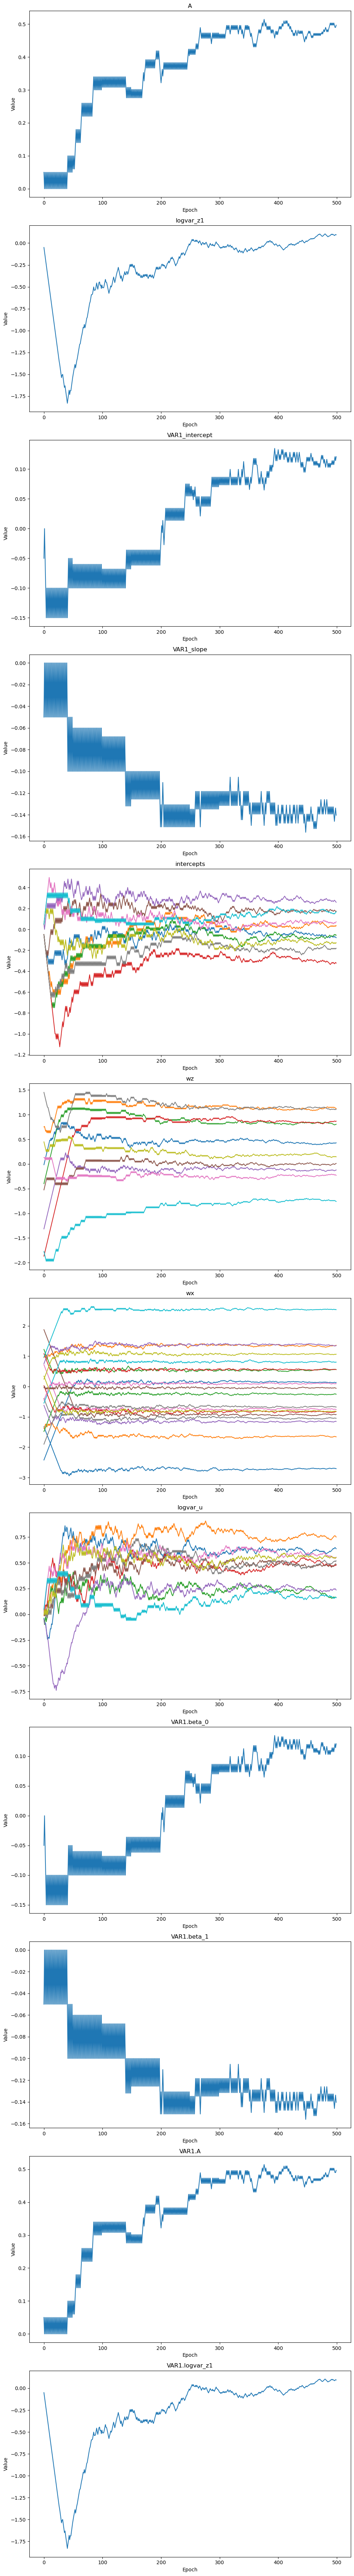

In [8]:

def plot_param_evolution(all_params):
    """
    Plot the evolution of model parameters across epochs.

    Parameters:
    - all_params (list): A list containing the state_dict of the model for each epoch.

    Returns:
    - None
    """

    # Convert model parameters to a format suitable for plotting
    param_timeseries = {}

    for epoch_params in all_params:
        for param_name, param_value in epoch_params.items():
            param_flat = param_value.cpu().numpy().flatten()  # flatten the tensor
            
            if param_name not in param_timeseries:
                param_timeseries[param_name] = []
            
            param_timeseries[param_name].append(param_flat)

    # Plot each parameter's evolution over epochs
    num_params = len(param_timeseries)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 6 * num_params))

    for ax, (param_name, time_series) in zip(axes, param_timeseries.items()):
        time_series = np.array(time_series)
        
        for i in range(time_series.shape[1]):
            ax.plot(time_series[:, i], label=f"Element {i}")
            
        ax.set_title(param_name)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        # ax.legend()  # Uncomment if you want a legend for each flattened element

    plt.tight_layout()
    plt.show()

plot_param_evolution(all_params)

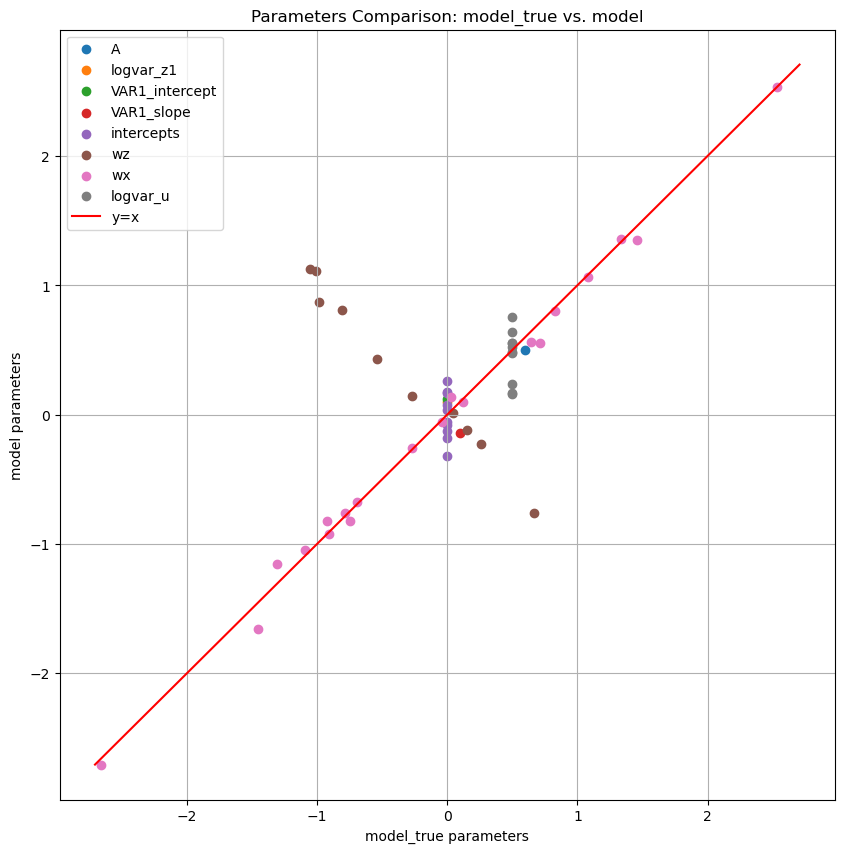

In [9]:
import matplotlib.pyplot as plt

def compare_model_parameters(model_true, model):
    """
    Scatter plot parameters of model_true against those of model.

    Parameters:
    - model_true (nn.Module): Ground truth or reference model.
    - model (nn.Module): Model to compare against the reference.

    Returns:
    - None
    """

    # Define the line with slope 1, intercept 0
    max_val = float('-inf')

    # Create a new figure
    plt.figure(figsize=(10, 10))
    
    # Loop through parameters in both models
    for (param_name_true, param_true), (_, param) in zip(model_true.named_parameters(), model.named_parameters()):
        # Flatten the parameters for plotting
        param_true_flat = param_true.detach().cpu().numpy().flatten()
        param_flat = param.detach().cpu().numpy().flatten()
        
        # Scatter plot
        plt.scatter(param_true_flat, param_flat, label=param_name_true)
        
        # Determine maximum absolute value for plotting
        max_val = max(max_val, np.abs(param_true_flat).max(), np.abs(param_flat).max())

    # Plot the red line
    plt.plot([-max_val, max_val], [-max_val, max_val], 'r', label='y=x')
    
    plt.title('Parameters Comparison: model_true vs. model')
    plt.xlabel('model_true parameters')
    plt.ylabel('model parameters')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
compare_model_parameters(model_true, model)


In [10]:
encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
_, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])

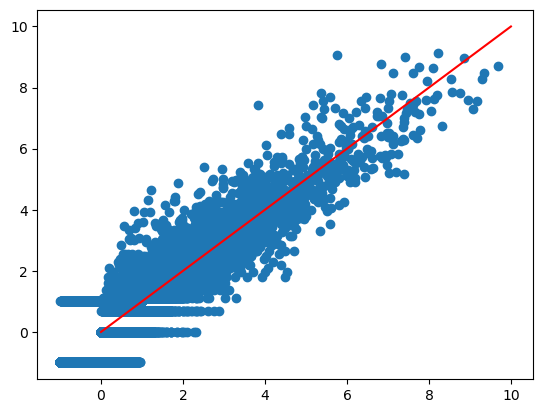

In [11]:
plt.scatter(model.transform_responses(decoded_mean).detach().numpy(), model.transform_responses(y_nomis).detach().numpy())
plt.plot([0,10],[0,10], color="red")

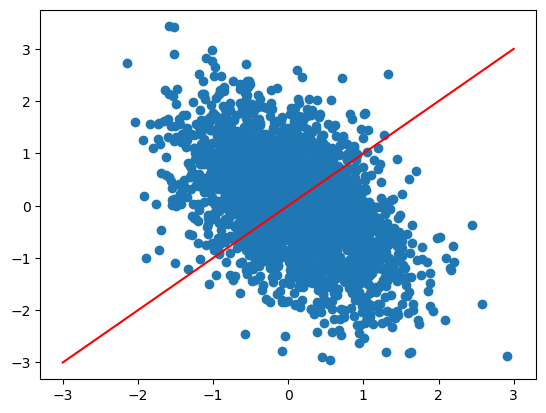

In [12]:
plt.scatter(encoded_epsilon.detach(), data_true['epsilon'].detach())
plt.plot([-3,3], [-3,3], color="red")

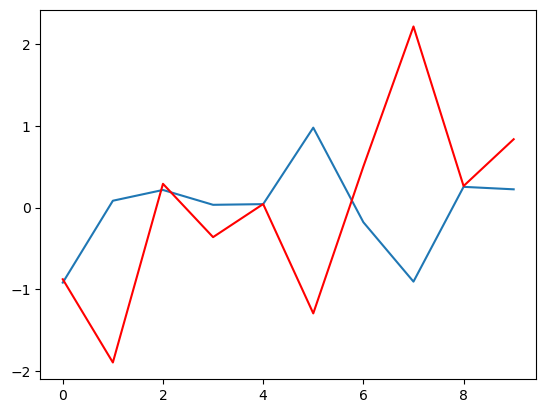

In [13]:
plt.plot(encoded_epsilon[0,:,0].detach())
plt.plot(data_true['epsilon'][0,:,0].detach(), color="red")

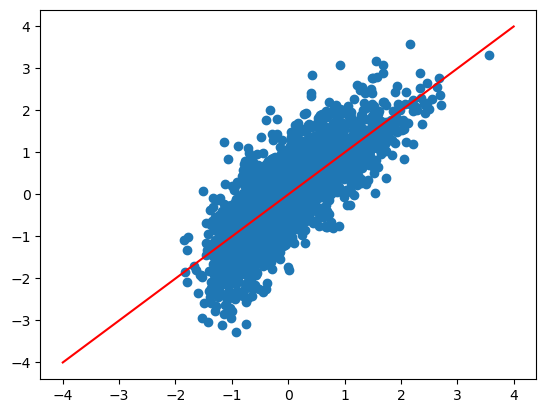

In [14]:
plt.scatter(encoded_u.detach(), data_true['u'].detach())
plt.plot([-4,4], [-4,4], color="red")